# Project US Airline Twiter
1. Import the Libraries
2. Import the datasets and remove the unwanted features
3. Cleaning the data 
4. Creating the vocab and data formatting
5. split the train datasets and predict the score 
6. Save the data


In [113]:
# Import the Libaries

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re
from nltk.corpus import stopwords
from string import punctuation

In [ ]:
# Import the data

train = pd.read_csv('training_twitter_x_y_train.csv')
test = pd.read_csv('test_twitter_x_test.csv')

In [114]:
# Remove the unwanted features

clean_col = ['tweet_id', 'airline_sentiment_gold', 'name', 'retweet_count', 'tweet_coord', 'tweet_created', 'tweet_location', 'user_timezone']
train.drop(clean_col, axis = 1, inplace  =  True)
test.drop(clean_col,axis = 1, inplace = True)

In [115]:
# stop_word and punctuations

stops = stopwords.words('english')
stops += list(punctuation)
stops += ['flight', 'airline', 'flights', 'AA']
abbreviations ={'ppl' : 'people','cust':'customer','serv':'service','mins':'minutes','hrs':'hours','svc': 'service','u':'you','pls':'please' }

In [170]:
train.head(5)

,airline_sentiment,airline,text
0,negative,Southwest,"scheduled morning, days fact, yes..not sure ev..."
1,positive,Southwest,seeing workers time time going beyond love fly...
2,positive,United,"flew ord miami back great crew, service legs. ..."
3,negative,Southwest,that's horse radish Southwest
4,negative,United,"ord delayed air force one, last sbn minutes la..."


In [117]:
# Sample data

tweet = train.loc[0, 'text']
tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',tweet) #remove links
tweet = re.sub('@[^\s]+','',tweet) #remove usernames
tweet = re.sub('[\s]+', ' ', tweet) #remove additional whitespaces
tweet = re.sub(r'#([^\s]+)', r'\1', tweet) #replace #word with word
tweet = tweet.strip('\'"') #trim tweet
tweet

' I am scheduled for the morning, 2 days after the fact, yes..not sure why my evening flight was the only one Cancelled Flightled'

In [171]:
# Sample Data
word1 = "Hey there"
word2 = "What can I help you"
word1 = " %s %s" % (word1, word2)
word1

' Hey there What can I help you'

In [119]:
# Store the indexes where negativereason_gold is not NULL
train_index = train[~train.negativereason_gold.isna()].index
test_index = test[~test.negativereason_gold.isna()].index

# Training Data

for index, row in train.iterrows():
    tweet = row.text
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',tweet) #remove links
    tweet = re.sub('@[^\s]+','',tweet) #remove usernames
    tweet = re.sub('[\s]+', ' ', tweet) #remove additional whitespaces
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet) #replace #word with word
    tweet = tweet.strip('\'"') #trim tweet
    words = []
    for word in tweet.split(): 
        if word.lower() not in stops:
            if word in list(abbreviations.keys()):
                words.append(abbreviations[word])
            else:
                words.append(word.lower())   
    tweet = " ".join(words)
    tweet = " %s %s" % (tweet, row.airline)
    row.text = tweet
    if index in train_index:
        row.text = " %s %s" % (row.text, row.negativereason_gold)

# Testing Data

for index, row in test.iterrows():
    tweet = row.text
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',tweet) #remove links
    tweet = re.sub('@[^\s]+','',tweet) #remove usernames
    tweet = re.sub('[\s]+', ' ', tweet) #remove additional whitespaces
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet) #replace #word with word
    tweet = tweet.strip('\'"') #trim tweet
    words = []
    for word in tweet.split(): 
#         if not hasNumbers(word):
        if word.lower() not in stops:
            if word in list(abbreviations.keys()):
                words.append(abbreviations[word])
            else:
                words.append(word.lower())
    tweet = " ".join(words)
    tweet = " %s %s" % (tweet, row.airline)
    row.text = tweet
    if index in test_index:
        row.text = " %s %s" % (row.text, row.negativereason_gold)

del train['negativereason_gold']
del test['negativereason_gold']
train.head()

,airline_sentiment,airline,text
0,negative,Southwest,"scheduled morning, 2 days fact, yes..not sure..."
1,positive,Southwest,seeing workers time time going beyond love fl...
2,positive,United,"flew ord miami back great crew, service legs...."
3,negative,Southwest,that's horse radish 😤🐴 Southwest
4,negative,United,"ord delayed air force one, last sbn 8:20, 5 m..."


In [120]:
# Decode the Emoji

def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

for index, row in train.iterrows():
    row.text = deEmojify(row.text)

for index, row in test.iterrows():
    row.text = deEmojify(row.text)

In [121]:
# Rmove the Numbers

def hasNumbers(inputString):
    return any(char.isdigit() for char in inputString)

for index, row in train.iterrows():
    words = row.text.split()
    new_words = []
    for word in words:
        if not hasNumbers(word):
            new_words.append(word)
    row.text = " ".join(new_words)
    
for index, row in test.iterrows():
    words = row.text.split()
    new_words = []
    for word in words:
        if not hasNumbers(word):
            new_words.append(word)
    row.text = " ".join(new_words)
        

In [122]:
train.head()

,airline_sentiment,airline,text
0,negative,Southwest,"scheduled morning, days fact, yes..not sure ev..."
1,positive,Southwest,seeing workers time time going beyond love fly...
2,positive,United,"flew ord miami back great crew, service legs. ..."
3,negative,Southwest,that's horse radish Southwest
4,negative,United,"ord delayed air force one, last sbn minutes la..."


In [152]:
# Creating Vocab and Data Formatting
v = TfidfVectorizer(analyzer='word', max_features=3150, max_df = 0.8, ngram_range=(1,1))

# Split the Training Data
x_train,x_test, y_train, y_test = train_test_split(train.text, train.airline_sentiment)
train_features= v.fit_transform(x_train)
test_features=v.transform(x_test)

In [153]:
# Applying Logistic Regression and measure its accuracy
accuracy = []
for c in range(5, 100):
    clf = LogisticRegression(C = c*0.1, solver = 'liblinear', multi_class = 'auto')
    clf.fit(train_features, y_train)
    accuracy.append(clf.score(test_features, y_test))

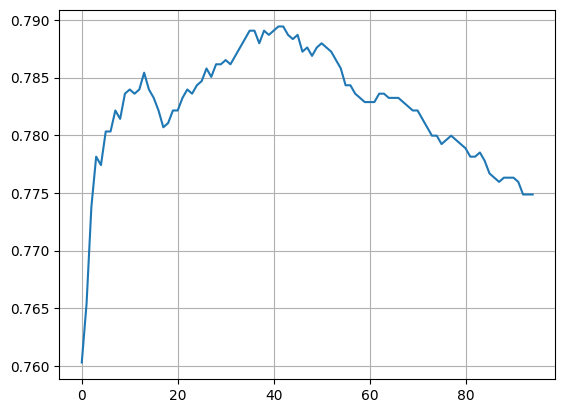

In [154]:
import matplotlib.pyplot as plt
plt.plot(range(len(accuracy)), accuracy)
plt.grid() 

In [161]:
clf = LogisticRegression(C = 2.1, solver='liblinear', multi_class='auto')
clf.fit(train_features,y_train)
clf.score(test_features, y_test)

0.7697632058287796

In [173]:
# Store the predicted values
train_data = v.fit_transform(train.text)
test_data = v.transform(test.text)
clf.fit(train_data, train.airline_sentiment)
pred = clf.predict(test_data)
with open('predictions_twitter.csv', 'w') as f:
    for item in pred:
        f.write("%s\n" % item)

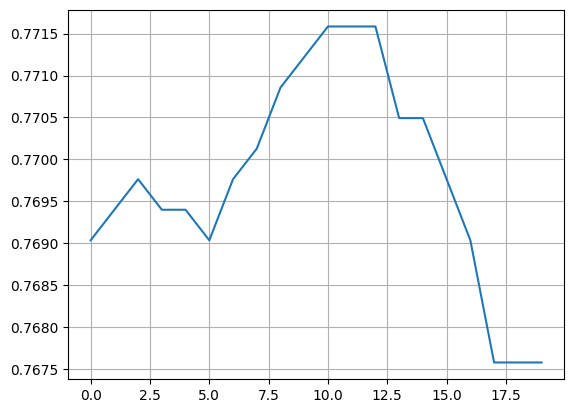

In [168]:
# Applying SVM 
train_features= v.fit_transform(x_train)
test_features=v.transform(x_test)
accuracy = []
for c in range(50, 70):
    clf = SVC(kernel = 'linear', C = c*0.02, gamma = 'scale')
    clf.fit(train_features, y_train)
    accuracy.append(clf.score(test_features, y_test))

plt.plot(range(len(accuracy)), accuracy)
plt.grid() 

In [ ]:
clf = SVC(kernel="linear", C= 1.20, gamma = 'scale')
clf.fit(train_features,y_train)
clf.score(test_features, y_test)

In [174]:
clf = SVC(kernel="linear", C= 1.20, gamma = 'scale')
clf.fit(train_data, train.airline_sentiment) 
pred = clf.predict(test_data)
with open('predictions_twitter2.csv', 'w') as f: #less accurate
    for item in pred:
        f.write("%s\n" % item)